In [8]:
%matplotlib inline
from detector import Detector
from utils import draw_bounding_boxes

In [9]:
state_file = "./epoch_41.pth.tar"
detector = Detector(state_file)

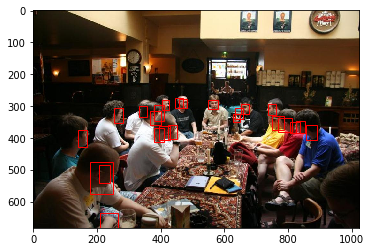

In [16]:
test_image = "/home/louis/datasets/wider_face/WIDER_val/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_441.jpg"
bboxes = detector.infer(test_image)
draw_bounding_boxes(test_image, bboxes)